In [26]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from typing import List
from dataclasses import dataclass
import scipy

In [2]:
@dataclass
class Gaussian:
    mean: np.ndarray
    cov: np.ndarray

@dataclass
class Observations:
    times: np.ndarray
    obs_ind: np.ndarray  # index of times that are observed
    obs: np.ndarray
    names: List[str]

@dataclass
class KFTracker:
    means: np.ndarray
    covs: np.ndarray
    stds: np.ndarray

In [3]:
def resample(Nsamples, samples, weights):
    """Generate *Nsamples* samples from an empirical distribution defined by *samples* and *weights*

    Inputs
    ------
    Nsamples: integer, number of samples to generate
    samples: (N, d) array of N samples of dimension d that form the empirical distribution
    weights: (N, ) array of N weights

    Returns
    --------
    samples_out: (Nsamples, d) new samples
    weights_out: (Nsamples, ) new weights equal to 1 / N
    """

    N = samples.shape[0]  # get number of points that make up the empirical distribution
    rr = np.arange(N) # get an ordered set of numbers from 0 to N-1

    # Randomly choose the integers (with replacement) between 0 to N-1 with probabilities given by the weights
    samp_inds = np.random.choice(rr, Nsamples, p=weights)

    # subselect the samples chosen
    samples_out = samples[samp_inds, :]

    # return uniform weights
    weights_out = np.ones((Nsamples))/Nsamples
    return samples_out, weights_out

In [4]:
def compute_mean_std(samples, weights):
    """Compute the mean and standard deviation of multiple empirical distirbution.

    Inputs
    ------
    samples: (N, d, m) array of samples defining the empirical distribution
    weights: (N, m) array of weights

    Returns
    -------
    means: (m, d) array of means
    stds: (m, d) array of standard deviations

    Notes
    -----
    m is the number of empirical distributions
    """

    N, d, m = samples.shape
    means = np.zeros((m, d))
    stds = np.zeros((m, d))
    for ii in range(m):
        means[ii, :] = np.dot(weights[:, ii], samples[:, :, ii])
        stds[ii, :] = np.sqrt(np.dot(weights[:, ii], (samples[:, :, ii] - np.tile(means[ii, :], (N, 1)))**2))
    return means, stds

In [5]:
def pendulum_dyn(current_state, dt=0.1):

    """Pendulum dynamics

    Inputs
    ------
    Current_state : either (2,) or (N, 2) for vectorized input
    """
    if current_state.ndim == 1:
        next_state = np.zeros((2))
        next_state[0] = current_state[0] + dt * current_state[1]
        next_state[1] = current_state[1] - dt * 9.81 * np.sin(current_state[0])
    else: # multiple inputs
        next_state = np.zeros(current_state.shape)
        next_state[:, 0] = current_state[:, 0] + dt * current_state[:, 1]
        next_state[:, 1] = current_state[:, 1] - dt * 9.81 * np.sin(current_state[:, 0])
    return next_state

def observe(current_state):
    if current_state.ndim == 1:
        out = np.zeros((1))
        out[0] = np.sin(current_state[0])
    else:
        out = np.zeros((current_state.shape[0], 1))
        out[:, 0] = np.sin(current_state[:, 0])
    return out

In [6]:
def motion_model(state, dt, g=9.81):
    return np.array([state[0] + state[1]*dt, state[1] - g*np.sin(state[0])*dt])

def motion_model_Jacobian(state, dt, g=9.81):
    """
    Jacobian of the motion model.

    Args:
        state (array_like): The current state of the system.
        dt (float): The time step.

    Returns:
        ndarray: The Jacobian matrix.
    """
    # Check if state is a single state vector or an array of state vectors
    if state.ndim > 1:
        return np.array([[[1, dt], [-g * np.cos(s[0]) * dt, 1]] for s in state])
    else:
        return np.array([[1, dt], [-g * np.cos(state[0]) * dt, 1]])

def observation_model_Jacobian(state, dt):
    return np.array([[np.cos(state[0]), 0]])

def observation_model(state):
    return np.array([np.sin(state[0])])

In [7]:
"""def EKF_prediction_step2(samples: np.ndarray, xi: Gaussian, dt: np.float32) -> np.ndarray:

    pred_mean = motion_model(np.mean(samples, axis=0), dt) + xi.mean
    J = motion_model_Jacobian(np.mean(samples, axis=0), dt)
    pred_cov = J @ np.cov(samples, rowvar=False) @ J.T + xi.cov

    nsamples = samples.shape[0]

    # generate samples from the predicted distribution
    pred_samples = np.random.multivariate_normal(pred_mean, pred_cov, nsamples)

    return pred_samples

def EKF_update_step2(data: np.ndarray, samples: np.ndarray, eta: Gaussian, dt: np.float32) -> np.ndarray:

    H = observation_model_Jacobian(np.mean(samples, axis=0), dt)
    U = np.dot(np.cov(samples, rowvar=False), H.T)
    S = np.dot(H, U) + eta.cov
    mu = np.dot(H, np.mean(samples, axis=0)) + eta.mean

    # kalman gain
    K = np.linalg.solve(S, H@np.cov(samples, rowvar=False)).T
    update_mean = np.mean(samples, axis=0) + K @ np.atleast_1d(data - mu)
    update_cov = np.cov(samples, rowvar=False) - K @ S @ K.T

    nsamples = samples.shape[0]
    update_samples = np.random.multivariate_normal(update_mean, update_cov, nsamples)

    return update_samples"""

'def EKF_prediction_step2(samples: np.ndarray, xi: Gaussian, dt: np.float32) -> np.ndarray:\n\n    pred_mean = motion_model(np.mean(samples, axis=0), dt) + xi.mean\n    J = motion_model_Jacobian(np.mean(samples, axis=0), dt)\n    pred_cov = J @ np.cov(samples, rowvar=False) @ J.T + xi.cov\n\n    nsamples = samples.shape[0]\n\n    # generate samples from the predicted distribution\n    pred_samples = np.random.multivariate_normal(pred_mean, pred_cov, nsamples)\n\n    return pred_samples\n\ndef EKF_update_step2(data: np.ndarray, samples: np.ndarray, eta: Gaussian, dt: np.float32) -> np.ndarray:\n\n    H = observation_model_Jacobian(np.mean(samples, axis=0), dt)\n    U = np.dot(np.cov(samples, rowvar=False), H.T)\n    S = np.dot(H, U) + eta.cov\n    mu = np.dot(H, np.mean(samples, axis=0)) + eta.mean\n\n    # kalman gain\n    K = np.linalg.solve(S, H@np.cov(samples, rowvar=False)).T\n    update_mean = np.mean(samples, axis=0) + K @ np.atleast_1d(data - mu)\n    update_cov = np.cov(samples

In [8]:
def EKF_prediction_step(samples: np.ndarray, xi: Gaussian, dt: np.float32) -> np.ndarray:
    
    if samples.ndim == 1:
        pred_samples = motion_model(samples, dt) + xi.mean

    else:
        pred_samples = np.zeros_like(samples)
        for i in range(samples.shape[0]):
            pred_samples[i] = motion_model(samples[i], dt) + xi.mean
    
    return pred_samples

def EKF_update_step(data: np.ndarray, samples: np.ndarray, eta: np.float32) -> np.ndarray:
    
    if samples.ndim == 1:
        updated_samples = eta*samples + (1-eta)*data
    
    else:   
        updated_samples = np.zeros_like(samples)
        for i in range(samples.shape[0]):
            updated_samples[i] = eta*samples[i] + (1-eta)*data
    
    return updated_samples

In [9]:
def ekf_proposal(current_state, xi, dt, data, Lproc, loop_index, obs_ind, eta):

    # do both the prediction and update steps of EKF
    if loop_index in obs_ind:
        prediction = EKF_prediction_step(current_state, xi, dt)
        return prediction

    # only provide prediction step output
    else:
        prediction = EKF_prediction_step(current_state, xi, dt)
        update = EKF_update_step(data, prediction, eta)
        return update 

def ekf_proposal_logpdf(current, previous, dt, data, proc_var, proc_mat_inv, loop_index, obs_ind, Lproc, xi, eta):

    # do both the prediction and update steps of EKF
    if loop_index in obs_ind:

      nexts1 = EKF_prediction_step(current, xi, dt)
      nexts = EKF_update_step(data, nexts1, eta)
      delta = nexts - current

    # do only prediction step
    else:

      nexts = EKF_prediction_step(current, xi, dt) #EKF_prediction_step(Gaussian(current, Lproc), xi, dt)
      #nexts = nexts.mean
      delta = nexts - current

    if current.ndim == 1:
        return -0.5 * np.dot(delta, np.dot(proc_mat_inv, delta))
    else:
        return -0.5 * np.sum(delta * np.dot(delta, proc_mat_inv.T), axis=1)

def ekf_likelihood(state, data, noise_var, loop_index):
    """Gaussian Likelihood through nonlinear model"""
    dpropose = observe(state)
    delta = dpropose - data
    if state.ndim == 1:
        return -0.5 * np.dot(delta, delta) / noise_var
    else:
        return -0.5 * np.sum(delta * delta, axis=1) / noise_var


def ekf_step(prop, proppdf, current_samples, current_weights, likelihood, data, propagator, dt, Lproc, proc_var, proc_mat_inv, noise_var, loop_index, xi, obs_ind, eta):

    new_samples = prop(current_samples, xi, dt, data, Lproc, loop_index, obs_ind, eta)

    new_weights = likelihood(new_samples, data, noise_var, loop_index) + propagator(new_samples, current_samples, dt, data, proc_var, proc_mat_inv, loop_index, obs_ind, Lproc, xi, eta) - \
                            proppdf(new_samples, current_samples, dt, data, proc_var, proc_mat_inv, loop_index, obs_ind, Lproc, xi, eta)
    
    log_weights = new_weights + np.log(current_weights)
    max_log_weight = np.max(log_weights)
    log_weights -= max_log_weight 
    weights = np.exp(log_weights)
    new_weights = weights / np.sum(weights)
    
    return new_samples, new_weights

def ekf_particle_filter(data, prior_mean, prior_cov,
                    prop, proppdf, likelihood, propagator, dt, Lproc, proc_var, proc_mat_inv, noise_var, xi, obs_ind, eta, time_instances_to_store, return_sample_memory=False, nsamples=1000, resampling_threshold_frac=0.1):

    d = prior_mean.shape[0]
    nsteps = data.shape[0]

    # create a sample memory for the 5 time instances
    sample_memory = []

    # Allocate memory
    samples = np.zeros((nsamples, d, nsteps+1))
    weights = np.zeros((nsamples, nsteps+1))
    eff = np.zeros((nsteps+1)) # keep track of effective sample size at each step


    # Generate initial samples from the prior
    L = np.linalg.cholesky(prior_cov)
    samples[:, :, 0] = np.tile(prior_mean, (nsamples, 1)) + np.dot(L, np.random.randn(d, nsamples)).T
    weights[:, 0] = 1.0 / nsamples # all weights are equal because of independent sampling from prior
    eff[0] = nsamples

    resamp_threshold = int(nsamples * resampling_threshold_frac)

    for ii in range(1, nsteps+1):

        samples[:, :, ii], weights[:, ii] = ekf_step(prop,  proppdf, samples[:, :, ii-1], weights[:, ii-1],
                                                 likelihood, data[ii-1, :], propagator, dt, Lproc, proc_var, proc_mat_inv, noise_var, ii, xi, obs_ind, eta)

        # compute the effective sample size
        eff[ii] = 1.0 / np.sum(weights[:, ii]**2)

        if ii % 50 == 0:
            print("eff = ", ii, eff[ii])

        # resample if effective sample size is below threshold
        if eff[ii] < resamp_threshold:
            samples[:, :, ii], weights[:, ii] = resample(nsamples, samples[:, :, ii], weights[:, ii])

        if ii in time_instances_to_store:
            sample_memory.append(samples[:, :, ii])
            
    if return_sample_memory:
        return samples, weights, eff, sample_memory
    else:
        return samples, weights, eff

## Combined Analysis

eff =  50 7635.36419367016
eff =  100 7191.961966071561
eff =  150 9628.148413253333
eff =  200 5663.240271219015
eff =  250 9968.203427420262
eff =  300 7145.16113603848
eff =  350 7057.805268084988
eff =  400 6954.4817376031715
eff =  450 6139.84461798636
eff =  500 6656.691412296297
eff =  50 6345.186179247981
eff =  100 7134.255686635179
eff =  150 6881.010514545255
eff =  200 7199.366424983804
eff =  250 7827.481280550435
eff =  300 9676.1434013795
eff =  350 9728.17077336844
eff =  400 9572.910039076749
eff =  450 9082.826561433558
eff =  500 9068.27696067906
eff =  50 9188.451056380924
eff =  100 8504.000000000498
eff =  150 8503.999999999996


C:\Users\soham\AppData\Local\Temp\ipykernel_584\4132510314.py:52: RuntimeWarning: divide by zero encountered in log
  log_weights = new_weights + np.log(current_weights)


eff =  200 8503.999999999996
eff =  250 8503.999999999996
eff =  300 8503.999999999996
eff =  350 8503.999999999996
eff =  400 8503.999999999996
eff =  450 8503.999999999996
eff =  500 8503.999999999996


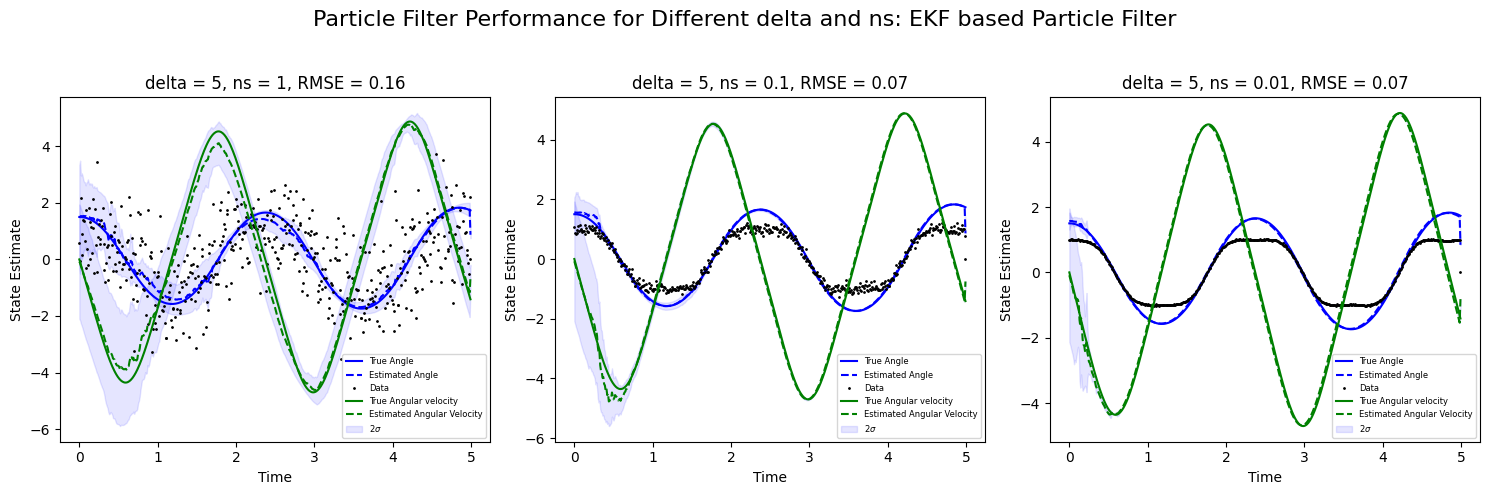

In [10]:
# Parameters
x0 = np.array([1.5, 0])  # Initial state
dt = 0.01  # Time step
Nsteps = 500  # Number of time steps
times = np.arange(0, Nsteps*dt, dt)  # Time array
num_samples = 10000  # Number of particles
resample_thresh = 0.5  # Resampling threshold
proc_var = 0.5  # Process noise variance

# create storage variables for samples
sample_memories = []

# Initialize process noise covariance matrix
proc_mat = np.zeros((2, 2))
proc_mat[0, 0] = proc_var / 3.0 * dt**3
proc_mat[0, 1] = proc_var / 2.0 * dt**2
proc_mat[1, 0] = proc_var / 2.0 * dt**2
proc_mat[1, 1] = proc_var * dt
proc_mat_inv = np.linalg.pinv(proc_mat)
Lproc = np.linalg.cholesky(proc_mat)
mm = np.zeros(2)                              # process model noise mean
xi = Gaussian(mm, proc_mat)                   # process noise

time_instances_to_store = np.array([60, 140, 220, 300, 380])
return_sample_memory = True

# Combinations of delta and ns
delta_values = [1]
ns_values = [1, 0.1, 0.01]
eta = 0.5

# Prepare the plot
if len(delta_values) == 1 and len(ns_values) == 1:
    fig, axs = plt.subplots(1, 1, figsize=(6, 5))
    fig.suptitle("Particle Filter Performance", fontsize=16)
else:
    fig, axs = plt.subplots(len(delta_values), len(ns_values), figsize=(15, 5))
    fig.suptitle("Particle Filter Performance for Different delta and ns: EKF based Particle Filter", fontsize=16)

# Loop over delta and ns
for i, delta in enumerate(delta_values):
    for j, ns in enumerate(ns_values):
        noise_var = ns * ns  # Variance of observation noise
        obs_ind = np.arange(0, Nsteps, delta)  # Observation indices
        data = np.zeros((len(obs_ind), 1))  # Observed data

        # Generate truth and observations
        true = np.zeros((Nsteps, 2))
        true[0, :] = x0
        obs_counter = 0

        for ii in range(1, Nsteps):
            true[ii, :] = pendulum_dyn(true[ii-1, :], dt=dt)
            if ii in obs_ind:
                data[obs_counter] = observe(true[ii, :]) + np.random.randn() * ns
                obs_counter += 1

        # Run particle filter
        if return_sample_memory == False:
            samples, weights, eff = ekf_particle_filter(
            data, true[0, :], np.eye(2), ekf_proposal, ekf_proposal_logpdf,
            ekf_likelihood, ekf_proposal_logpdf, dt, Lproc, proc_var, proc_mat_inv,
            noise_var, xi, obs_ind, eta, time_instances_to_store, return_sample_memory=return_sample_memory, nsamples=num_samples, resampling_threshold_frac=resample_thresh
        )
        else:
            samples, weights, eff, sample_memory = ekf_particle_filter(
            data, true[0, :], np.eye(2), ekf_proposal, ekf_proposal_logpdf,
            ekf_likelihood, ekf_proposal_logpdf, dt, Lproc, proc_var, proc_mat_inv,
            noise_var, xi, obs_ind, eta, time_instances_to_store, return_sample_memory=return_sample_memory, nsamples=num_samples, resampling_threshold_frac=resample_thresh
        )
            sample_memories.append(sample_memory)

        means, stds = compute_mean_std(samples, weights)

        # Compute RMSE
        RMSE = np.sqrt(np.mean((means[1:, 0] - true[obs_ind, 0])**2))

        if len(delta_values) == 1 and len(ns_values) == 1:
            axs.plot(times, true[:, 0], 'b-', label='True Angle')
            axs.plot(times[obs_ind], means[1:, 0], 'b--', label='Estimated Angle')
            axs.plot(times[obs_ind], data[:, 0], 'ko', ms=1, label='Data')
            axs.fill_between(times[obs_ind],
                        means[1:, 0] - 2 * stds[1:, 0],
                        means[1:, 0] + 2 * stds[1:, 0],
                        color='blue', alpha=0.1)
            
            axs.plot(times, true[:, 1], 'g-', label='True Angular velocity')
            axs.plot(times[obs_ind], means[1:, 1], 'g--', label='Estimated Angular Velocity')
            axs.fill_between(times[obs_ind],
                        means[1:, 1] - 2 * stds[1:, 1],
                        means[1:, 1] + 2 * stds[1:, 1],
                        color='blue', alpha=0.1, label=r'$2\sigma$')
            
            axs.set_title(f"delta = {5}, ns = {ns}, RMSE = {RMSE:.2f}")
            axs.set_xlabel("Time")
            axs.set_ylabel("State Estimate")
            axs.legend(fontsize=6)

        elif len(delta_values) == 1 and len(ns_values) > 1:
            # Plot results
            ax = axs[j]
            ax.plot(times, true[:, 0], 'b-', label='True Angle')
            ax.plot(times[obs_ind], means[1:, 0], 'b--', label='Estimated Angle')
            ax.plot(times[obs_ind], data[:, 0], 'ko', ms=1, label='Data')
            ax.fill_between(times[obs_ind],
                        means[1:, 0] - 2 * stds[1:, 0],
                        means[1:, 0] + 2 * stds[1:, 0],
                        color='blue', alpha=0.1)
            
            ax.plot(times, true[:, 1], 'g-', label='True Angular velocity')
            ax.plot(times[obs_ind], means[1:, 1], 'g--', label='Estimated Angular Velocity')
            ax.fill_between(times[obs_ind],
                        means[1:, 1] - 2 * stds[1:, 1],
                        means[1:, 1] + 2 * stds[1:, 1],
                        color='blue', alpha=0.1, label=r'$2\sigma$')

            ax.set_title(f"delta = {5}, ns = {ns}, RMSE = {RMSE:.2f}")
            ax.set_xlabel("Time")
            ax.set_ylabel("State Estimate")
            ax.legend(fontsize=6)

        else:
            # Plot results
            ax = axs[i, j]
            ax.plot(times, true[:, 0], 'b-', label='True Angle')
            ax.plot(times[obs_ind], means[1:, 0], 'b--', label='Estimated Angle')
            ax.plot(times[obs_ind], data[:, 0], 'ko', ms=1, label='Data')
            ax.fill_between(times[obs_ind],
                        means[1:, 0] - 2 * stds[1:, 0],
                        means[1:, 0] + 2 * stds[1:, 0],
                        color='blue', alpha=0.1)

            ax.plot(times, true[:, 1], 'g-', label='True Angular velocity')
            ax.plot(times[obs_ind], means[1:, 1], 'g--', label='Estimated Angular Velocity')
            ax.fill_between(times[obs_ind],
                        means[1:, 1] - 2 * stds[1:, 1],
                        means[1:, 1] + 2 * stds[1:, 1],
                        color='blue', alpha=0.1, label=r'$2\sigma$')

            ax.set_title(f"delta = {delta}, ns = {ns}, RMSE = {RMSE:.2f}")
            ax.set_xlabel("Time")
            ax.set_ylabel("State Estimate")
            ax.legend(fontsize=6)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

C:\Users\soham\AppData\Local\Temp\ipykernel_584\4213862906.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[j].legend()


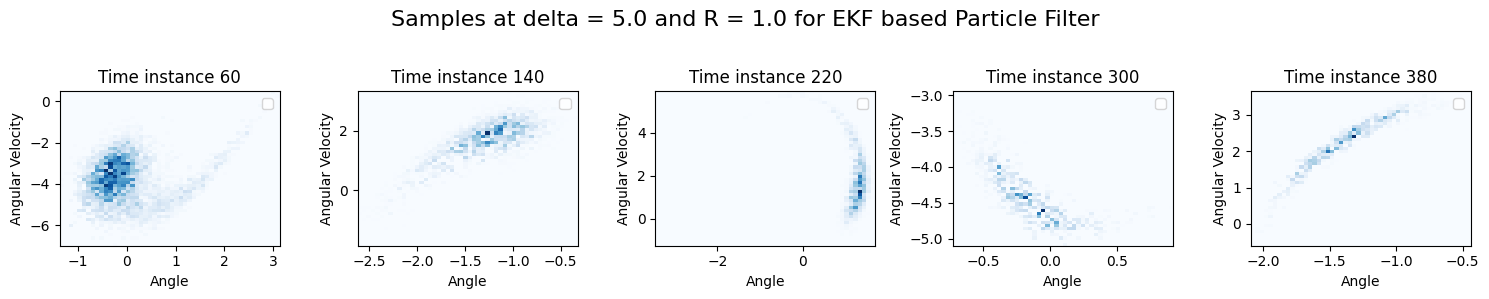

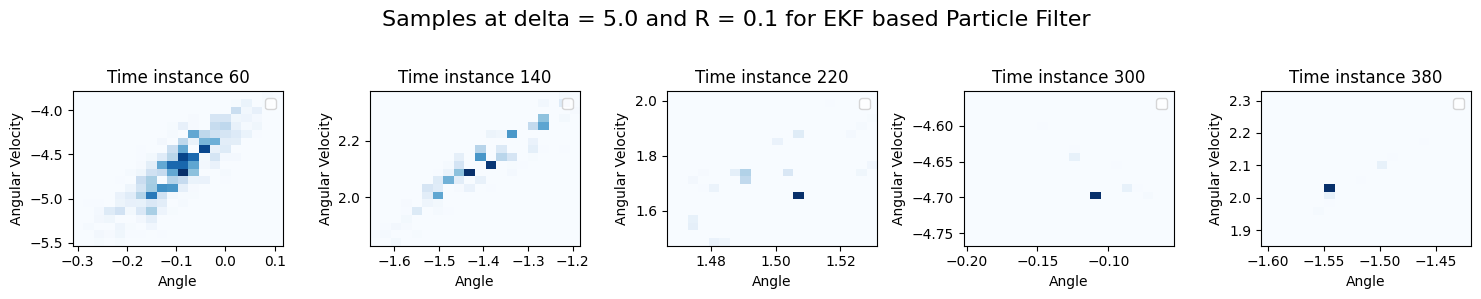

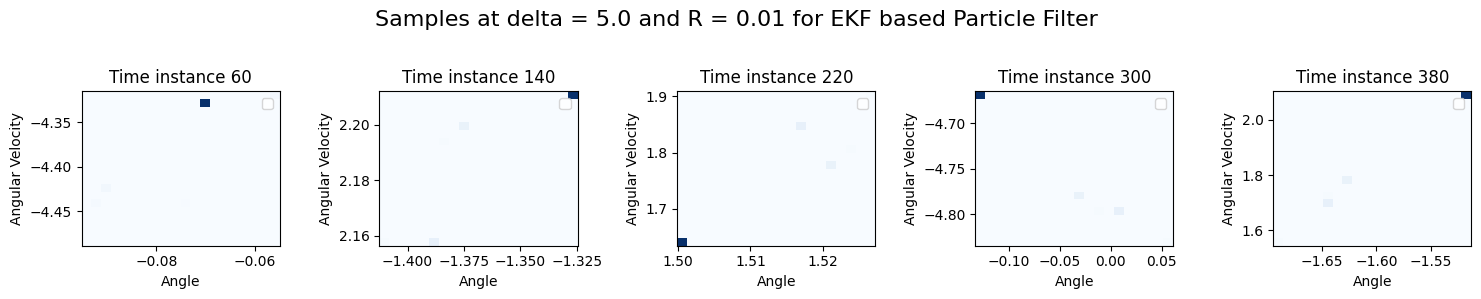

In [42]:
sample_memories = np.array(sample_memories)
bins =  np.array([50, 20, 20])
delta_R_pair = np.array([[5, 1], [5, 0.1], [5, 0.01]])
for i in range(len(sample_memories)):
    fig, axs = plt.subplots(1, 5, figsize=(15, 3))
    fig.suptitle(f"Samples at delta = {delta_R_pair[i][0]} and R = {delta_R_pair[i][1]} for EKF based Particle Filter", fontsize=16)
    for j in range(5):
        # plot 2D histogram
        axs[j].hist2d(sample_memories[i][j][:, 0], sample_memories[i][j][:, 1], bins=bins[i], cmap='Blues')
        axs[j].set_xlabel("Angle")
        axs[j].set_ylabel("Angular Velocity")
        axs[j].set_title(f"Time instance {time_instances_to_store[j]}")
        axs[j].legend()
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

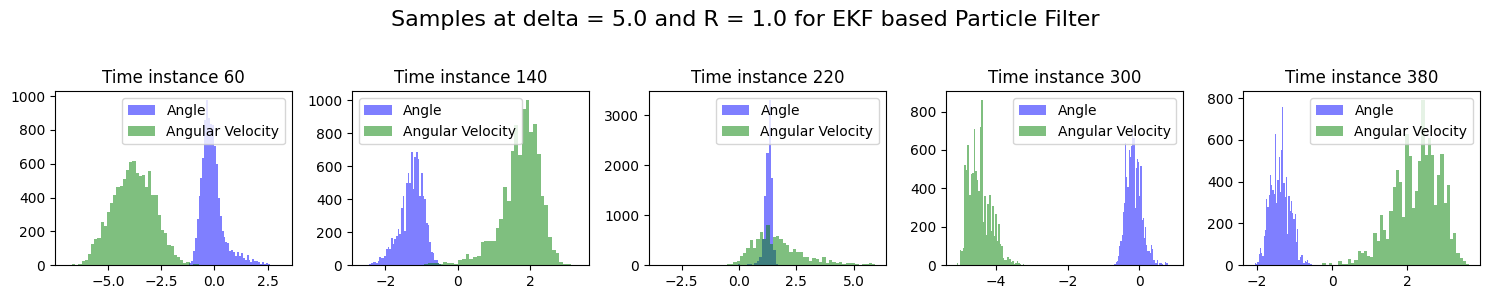

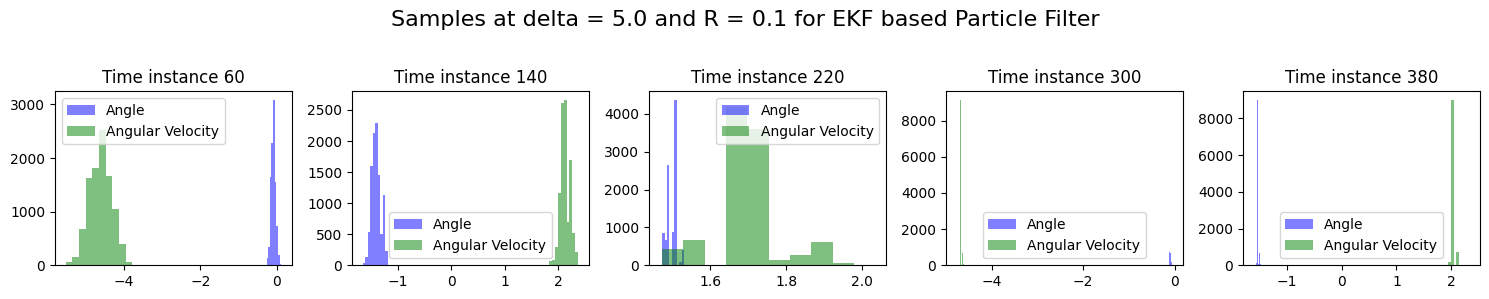

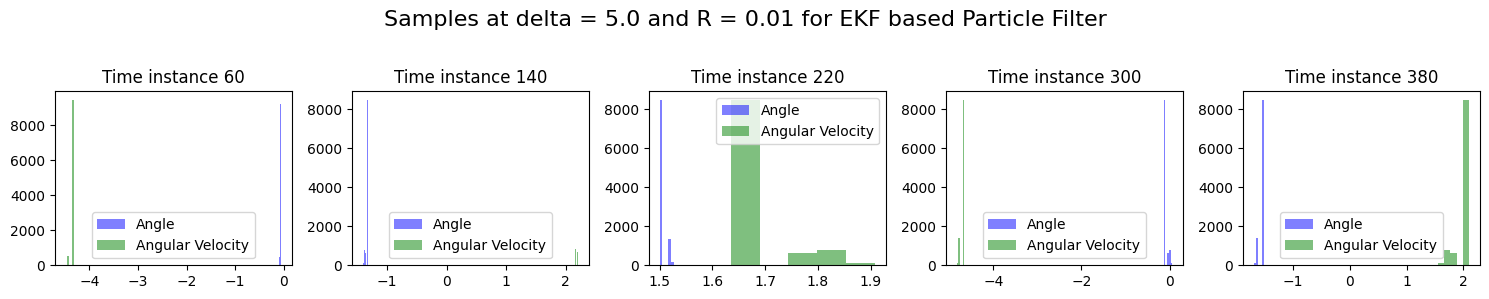

In [40]:
sample_memories = np.array(sample_memories)
bins =  np.array([50, 10, 5])
delta_R_pair = np.array([[5, 1], [5, 0.1], [5, 0.01]])
for i in range(len(sample_memories)):
    fig, axs = plt.subplots(1, 5, figsize=(15, 3))
    fig.suptitle(f"Samples at delta = {delta_R_pair[i][0]} and R = {delta_R_pair[i][1]} for EKF based Particle Filter", fontsize=16)
    for j in range(5):
        axs[j].hist(sample_memories[i][j][:, 0], bins=bins[i], color='blue', alpha=0.5, label='Angle')
        
        # fit a gaussian use scipy.stats.fit
        #mean, std = sample_memories[i][j][:, 0].mean(), sample_memories[i][j][:, 0].std()
        #x = np.linspace(mean - 3*std, mean + 3*std, 100)
        #y = scipy.stats.norm.pdf(x, mean, std)
        #axs[j].plot(x, y, 'r--', label='Gaussian Fit')

        axs[j].hist(sample_memories[i][j][:, 1], bins=bins[i], color='green', alpha=0.5, label='Angular Velocity')
        
        # fit a gaussian


        axs[j].set_title(f"Time instance {time_instances_to_store[j]}")
        axs[j].legend()
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

In [ ]:
# plot a 

array([[-0.06919491, -4.32985886],
       [-0.06919491, -4.32985886],
       [-0.06919491, -4.32985886],
       ...,
       [-0.06919491, -4.32985886],
       [-0.06919491, -4.32985886],
       [-0.06919491, -4.32985886]])

## Individual Analysis

In [ ]:
x0 = np.array([1.5, 0])                       # initial state
dt = 0.01                                     # time step
Nsteps = 500                                  # number of time steps
g = 9.8                                       # gravity
true = np.zeros((Nsteps, 2))                  # Allocate memory for truth
true[0, :] = x0                               # Assign x0 to initial truth value
delta = 1                                     # observation frequency
obs_counter = 0                               # initialize observation counter
times = np.arange(0, Nsteps*dt, dt)           # initialize time array
obs_ind = np.arange(0, Nsteps, delta)         # initialize observation indices
data = np.zeros((len(obs_ind), 1))            # allocate memory for observed data

ns = 1.0                                      # standard deviation of observation noise
noise_var = ns*ns                             # variance of observation noise
eta = 0.3                                     # kalman filter weight
#eta = Gaussian(0, ns)

num_samples = 1000                            # number of particles
resample_thresh = 0.1                         # resampling threshold

proc_var = 0.5                                # Process noise variance
proc_mat = np.zeros((2, 2))                   # initialize process noise covariance matrix
proc_mat[0, 0] = proc_var/3.0*dt**3           # populate process noise covariance matrix
proc_mat[0, 1] = proc_var/2.0*dt**2           #
proc_mat[1, 0] = proc_var/2.0*dt**2           #
proc_mat[1, 1] = proc_var*dt                  #
proc_mat_inv = np.linalg.pinv(proc_mat)       # Compute Cholesky decomposition
Lproc  = np.linalg.cholesky(proc_mat)
mm = np.zeros(2)                              # process model noise mean
xi = Gaussian(mm, proc_mat)                   # process noise


prior_mean = true[0, :]                       # start at the truth -- this is obviously not possible in reality
prior_cov = np.eye(2)                         # identity covariance

# loop to collect truth data and observations
for ii in range(1, Nsteps):
    true[ii, :] = pendulum_dyn(true[ii-1, :],dt=dt)
    if ii in obs_ind:
        data[obs_counter] = observe(true[ii, :]) + np.random.randn()*ns
        obs_counter += 1

In [ ]:
ekf_samples, ekf_weights, ekf_eff =  ekf_particle_filter(data, prior_mean, prior_cov,
                                            ekf_proposal, ekf_proposal_logpdf, ekf_likelihood, ekf_proposal_logpdf, dt, Lproc, proc_var, proc_mat_inv, noise_var, xi, obs_ind, eta,
                                            nsamples=num_samples, resampling_threshold_frac=resample_thresh)

means_ekf, stds_ekf = compute_mean_std(ekf_samples, ekf_weights)

TypeError: ekf_particle_filter() missing 1 required positional argument: 'time_instances_to_store'

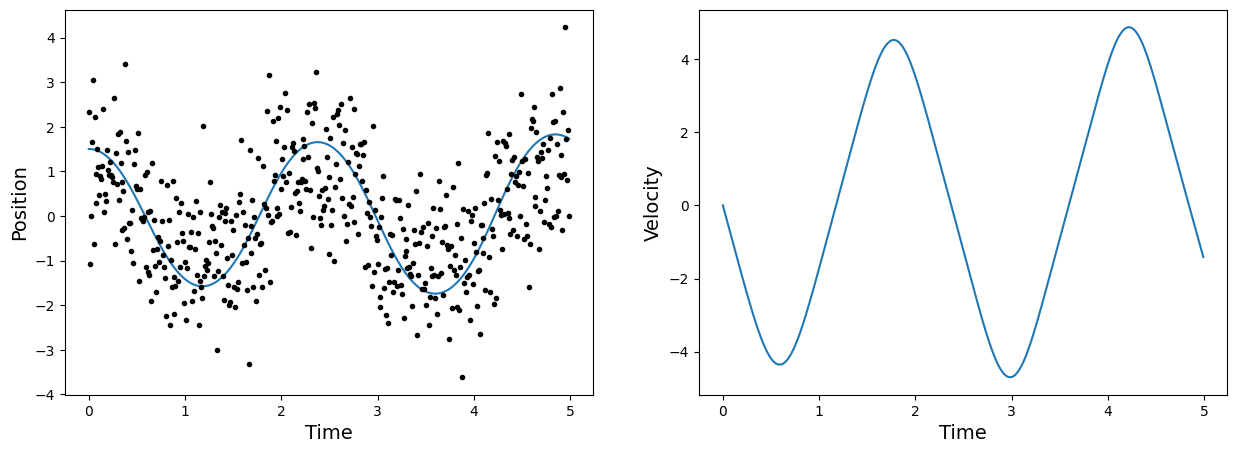

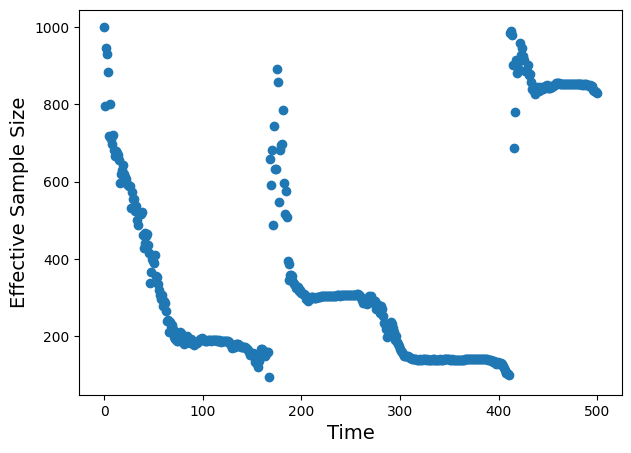

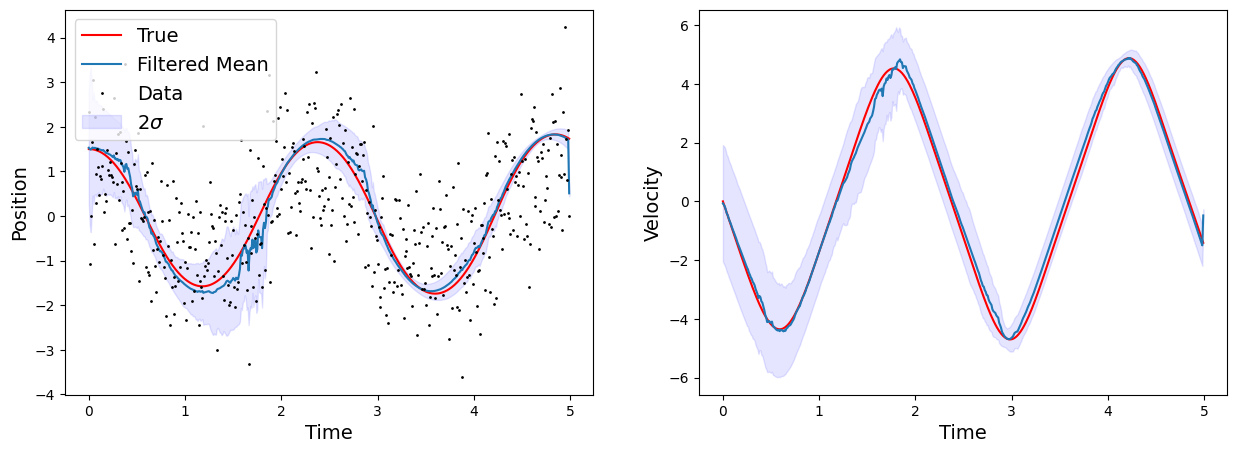

In [ ]:
# visualize the states and observations
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].plot(times, true[:, 0])
axs[0].plot(times[obs_ind], data, 'ko', ms=3)
axs[0].set_xlabel("Time", fontsize=14)
axs[0].set_ylabel("Position", fontsize=14)
axs[1].plot(times, true[:, 1])
axs[1].set_xlabel("Time", fontsize=14)
axs[1].set_ylabel("Velocity", fontsize=14)
plt.show()

# visualize effective sample size
plt.figure(figsize=(7,5))
plt.plot(ekf_eff, 'o')
plt.xlabel("Time", fontsize=14)
plt.ylabel("Effective Sample Size", fontsize=14)
plt.show()

# visualize filtered data
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].plot(times, true[:, 0],'-r', label='True')
axs[0].plot(times[obs_ind], means_ekf[1:, 0], '-', label='Filtered Mean')
axs[0].plot(times[obs_ind], data[:, 0], 'ko', ms=1, label='Data')
axs[0].fill_between(times[obs_ind], means_ekf[1:, 0] - 2 * stds_ekf[1:, 0], means_ekf[1:, 0]+2*stds_ekf[1:, 0], color='blue', alpha=0.1, label=r'$2\sigma$')
axs[0].set_xlabel('Time',fontsize=14)
axs[0].set_ylabel('Position', fontsize=14)
axs[0].legend(fontsize=14)

axs[1].plot(times, true[:, 1],'-r', label='True')
axs[1].plot(times[obs_ind], means_ekf[1:, 1], '-', label='Filtered Mean')
axs[1].fill_between(times[obs_ind], means_ekf[1:, 1] - 2 * stds_ekf[1:, 1], means_ekf[1:, 1]+2*stds_ekf[1:, 1], color='blue', alpha=0.1, label=r'$2\sigma$')
axs[1].set_xlabel('Time',fontsize=14)
axs[1].set_ylabel('Velocity', fontsize=14)

plt.show()